### Cell 1: Imports

In [1]:
import pandas as pd
import numpy as np
# import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
# If you are continuing directly from the previous cell, use df_feat.
# If loading from disk, uncomment the line below:
df_feat = pd.read_parquet("../data/engineered_features_16h.parquet")

print(f"Data Shape: {df_feat.shape}")

Data Shape: (9101, 53)


### MESSING AROUND

In [2]:
# Cell 2: Prepare X and y

# 1. Define Target
# Copy the label to ensure we don't modify the original dataframe in place unexpectedly later
y = df_feat['label'].copy()

# 2. Map Labels for XGBoost/Model Compatibility
# Current: -1 (Sell), 0 (Range), 1 (Buy)
# Mapped:   0 (Sell), 1 (Range), 2 (Buy)
label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)

# 3. Define Features (X)
# List of columns to drop (cleaned of syntax errors)
drop_cols = [
    'sess_tokyo_london', 'sess_asian_lunch', 'label', 
    'open', 'high', 'low', 'close', 
    'tick_volume', 'spread', 'atr',
    'rsi_7', 'rsi_21',
    'sess_dead_zone', 'sess_ny', 'sess_london', 
    'sess_sydney', 'hour_sin', 'day_cos',
    'roll_kurt_20'
]

# Calculate the intersection to avoid KeyErrors if a column is already missing
cols_to_drop = [c for c in drop_cols if c in df_feat.columns]

# Create the feature matrix X
X = df_feat.drop(columns=cols_to_drop)

print(f"Features (X) Shape: {X.shape}")
print(f"Target (y) Shape: {y_mapped.shape}")
print(f"Class Balance:\n{y_mapped.value_counts(normalize=True)}")

Features (X) Shape: (9101, 34)
Target (y) Shape: (9101,)
Class Balance:
label
1    0.508296
2    0.246896
0    0.244808
Name: proportion, dtype: float64


### # Cell 3: Chronological Split

In [3]:
# Cell 3: Chronological Split

# We'll use the first 80% for training, last 20% for validation
split_point = int(len(X) * 0.80)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]

y_train = y_mapped.iloc[:split_point]
y_test = y_mapped.iloc[split_point:]

print(f"Training Samples: {len(X_train)} (Start: {X_train.index[0]} - End: {X_train.index[-1]})")
print(f"Testing Samples:  {len(X_test)}  (Start: {X_test.index[0]} - End: {X_test.index[-1]})")

Training Samples: 7280 (Start: 2020-02-20 14:00:00 - End: 2024-10-22 18:00:00)
Testing Samples:  1821  (Start: 2024-10-22 22:00:00 - End: 2025-12-24 02:00:00)


### RANDOMISED SEARCH CV

In [ ]:
# import contextlib
# import joblib
# from tqdm.auto import tqdm
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from scipy.stats import randint, uniform

# @contextlib.contextmanager
# def tqdm_joblib(tqdm_object):
#     """Context manager to patch joblib to report into tqdm progress bar"""
#     class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
#         def __call__(self, *args, **kwargs):
#             tqdm_object.update(n=self.batch_size)
#             return super().__call__(*args, **kwargs)

#     old_batch_callback = joblib.parallel.BatchCompletionCallBack
#     joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
#     try:
#         yield tqdm_object
#     finally:
#         joblib.parallel.BatchCompletionCallBack = old_batch_callback
#         tqdm_object.close()



# # ==========================================
# # 1. SETUP DATA (Assuming X and y are ready)
# # ==========================================
# # X = df[features]
# # y = df['target'] (Values: -1, 0, 1 or "Sell", "Range", "Buy")

# # ==========================================
# # 2. THE "NO COMPROMISE" CONFIGURATION
# # ==========================================

# # A. The Validation Strategy
# # STRICT Time Series Split. 
# # We use 5 splits with a gap to prevent leakage between train/test windows.
# tscv = TimeSeriesSplit(n_splits=5, gap=50) 

# # B. The Search Space (Probability Distributions)
# # We use distributions to find the "Sweet Spot" mathematically.
# param_dist = {
#     # TREES: More is usually better but diminishing returns. 
#     # We search 200-800 to find the stability point.
#     'n_estimators': randint(200, 800),

#     # DEPTH: The most critical setting for overfitting.
#     # A range of 3-12 forces the model to simplify its logic. 
#     # If it needs depth 20, it's memorizing noise.
#     'max_depth': randint(3, 12),

#     # CONFIDENCE: min_samples_leaf ensures a rule applies to many samples.
#     # We look for leaves containing 20 to 100 samples.
#     # This prevents the model from creating a rule for just 1-2 specific candles.
#     'min_samples_leaf': randint(20, 100),

#     # RANDOMNESS: Helps decorrelate trees
#     'max_features': ['sqrt', 'log2'],

#     # CRITICAL: CLASS WEIGHTS
#     # 'balanced_subsample' calculates weights for EACH bootstrap sample.
#     # This aggressively penalizes the model for ignoring Buy/Sell signals.
#     'class_weight': ['balanced', 'balanced_subsample'],
    
#     # QUALITY: Gini is faster, Entropy sometimes finds better gradients.
#     'criterion': ['gini', 'entropy']
# }

# # ==========================================
# # 3. EXECUTION
# # ==========================================
# print("Starting SOTA Hyperparameter Optimization...")

# rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=100,              # 100 unique combinations (High compute, high confidence)
#     scoring='f1_macro',      # CRITICAL: Optimizes for the AVERAGE score of all classes (Buy/Sell/Range)
#     cv=tscv,                 # Respects time order
#     # n_jobs=-1,               # Uses all CPU cores
#     verbose=1,
#     random_state=42,
#     return_train_score=True  # Lets us check for overfitting later
# )

# # --- EXECUTION WITH PROGRESS BAR ---

# # 1. Calculate total jobs for the progress bar
# # Total jobs = n_iter * number of splits in your CV
# total_jobs = 100 * 5  # Based on n_iter=100 and TimeSeriesSplit(n_splits=5)

# print(f"Starting SOTA Hyperparameter Optimization ({total_jobs} total fits)...")

# # 2. Run the search with the progress bar
# with tqdm_joblib(tqdm(desc="Optimizing", total=total_jobs)) as progress_bar:
#     search.fit(X, y)

# # 3. Done
# print("\nOptimization Complete.")
# print(f"Best Score (Macro F1): {search.best_score_:.4f}")
# print(search.best_params_)


# # Train the final "Best" model on the most recent data chunk to see specific metrics
# best_model = search.best_estimator_

# # If you want to see if we fixed the Class Imbalance:
# from sklearn.metrics import classification_report
# # Note: In a real backtest, you would evaluate this on a hold-out "future" set.
# # For now, we inspect the best model's behavior on the last split of data.
# test_index = list(tscv.split(X))[-1][1] 
# X_test_last, y_test_last = X.iloc[test_index], y.iloc[test_index]
# y_pred = best_model.predict(X_test_last)

# print("\n--- FINAL VALIDATION (Last Split) ---")
# print(classification_report(y_test_last, y_pred))

### output of the above model

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Optimization Complete.
Best Score (Macro F1): 0.3926
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 79, 'n_estimators': 213}

--- FINAL VALIDATION (Last Split) ---
              precision    recall  f1-score   support

        -1.0       0.31      0.54      0.40       325
         0.0       0.64      0.58      0.61       804
         1.0       0.49      0.28      0.36       387

    accuracy                           0.50      1516
   macro avg       0.48      0.47      0.46      1516
weighted avg       0.53      0.50      0.50      1516

### saving the model -- already saved

In [ ]:
# import os

# # --- 2. SAVE THE MODEL ---
# # Define path
# model_dir = '../models'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# filename = 'rf_best_model_macro_f1_39.joblib'
# file_path = os.path.join(model_dir, filename)

# # Save the object
# print(f"Saving model to {file_path}...")
# joblib.dump(best_model, file_path)

# # --- 3. SAVE METADATA (Crucial for later) ---
# # We also need to save exactly WHICH features this model used, 
# # otherwise we can't use it for prediction later.
# metadata = {
#     'features': list(X_train.columns),
#     'target_mapping': label_mapping,
#     'best_params': search.best_params_,
#     'best_score': search.best_score_
# }
# joblib.dump(metadata, os.path.join(model_dir, 'rf_best_model_metadata.joblib'))

# print("Model and Metadata saved successfully.")

### . Extract Feature Importance

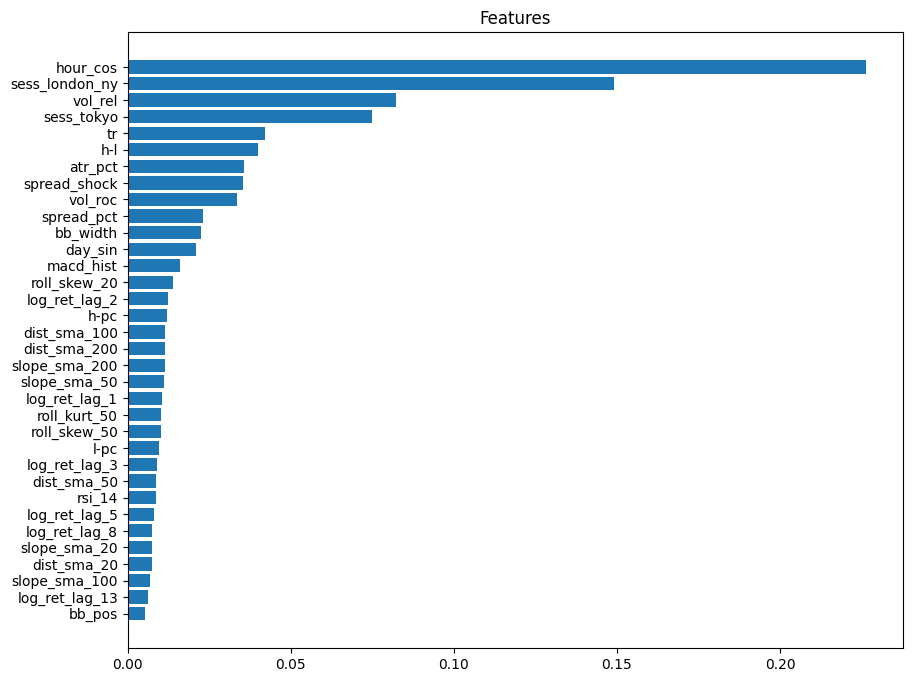

           Feature  Importance
4         hour_cos    0.226359
7   sess_london_ny    0.149096
10         vol_rel    0.082213
6       sess_tokyo    0.075021
3               tr    0.042105
0              h-l    0.039838
17         atr_pct    0.035738
9     spread_shock    0.035466
11         vol_roc    0.033524
8       spread_pct    0.022950
12        bb_width    0.022377
5          day_sin    0.020855
19       macd_hist    0.015936
14    roll_skew_20    0.013715
29   log_ret_lag_2    0.012448
1             h-pc    0.011919
24    dist_sma_100    0.011487
26    dist_sma_200    0.011381
27   slope_sma_200    0.011370
23    slope_sma_50    0.011153
28   log_ret_lag_1    0.010492
16    roll_kurt_50    0.010109
15    roll_skew_50    0.010019
2             l-pc    0.009544
30   log_ret_lag_3    0.009014
22     dist_sma_50    0.008767
18          rsi_14    0.008646
31   log_ret_lag_5    0.008004
32   log_ret_lag_8    0.007547
21    slope_sma_20    0.007458
20     dist_sma_20    0.007331
25   slo

In [5]:
import joblib
best_model = joblib.load('../models/rf_best_model_macro_f1_39.joblib')

importances = best_model.feature_importances_
feature_names = X_train.columns

# 3. Create a DataFrame and Sort
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# 4. Visualize
plt.figure(figsize=(10, 8))
plt.barh(feat_df['Feature'], feat_df['Importance']) # Top 20
plt.gca().invert_yaxis()
plt.title("Features")
plt.show()

# 5. The "Kill List"
# print("Bottom 10 Features (Likely Noise):")
print(feat_df)